In [33]:
import data as nfl
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

plt.style.use("ggplot")
pd.set_option("display.max_columns", 7)

In [34]:
TEST_YEAR = 2023

In [35]:
data = pd.concat(
    [nfl.get_pbp_data(season).assign(season=season) for season in range(1999, 2025)]
)

In [36]:
def dynamic_window_ewma(x):
    """
    Calculate rolling exponentially weighted EPA with a dynamic window size
    """
    values = np.zeros(len(x))
    for i, (_, row) in enumerate(x.iterrows()):
        epa = x.epa_shifted[: i + 1]
        if row.week > 10:
            values[i] = epa.ewm(min_periods=1, span=row.week).mean().values[-1]
        else:
            values[i] = epa.ewm(min_periods=1, span=10).mean().values[-1]

    return pd.Series(values, index=x.index)

In [37]:
# seperate EPA in to rushing offense, rushing defense, passing offense, passing defense for each team
rushing_offense_epa = (
    data.loc[data["rush_attempt"] == 1, :]
    .groupby(["posteam", "season", "week"], as_index=False)["epa"]
    .mean()
)

rushing_defense_epa = (
    data.loc[data["rush_attempt"] == 1, :]
    .groupby(["defteam", "season", "week"], as_index=False)["epa"]
    .mean()
)

passing_offense_epa = (
    data.loc[data["pass_attempt"] == 1, :]
    .groupby(["posteam", "season", "week"], as_index=False)["epa"]
    .mean()
)

passing_defense_epa = (
    data.loc[data["pass_attempt"] == 1, :]
    .groupby(["defteam", "season", "week"], as_index=False)["epa"]
    .mean()
)

# lag EPA one period back
rushing_offense_epa["epa_shifted"] = rushing_offense_epa.groupby("posteam")[
    "epa"
].shift()
rushing_defense_epa["epa_shifted"] = rushing_defense_epa.groupby("defteam")[
    "epa"
].shift()
passing_offense_epa["epa_shifted"] = passing_offense_epa.groupby("posteam")[
    "epa"
].shift()
passing_defense_epa["epa_shifted"] = passing_defense_epa.groupby("defteam")[
    "epa"
].shift()

# In each case, calculate EWMA with a static window and dynamic window and assign it as a column
rushing_offense_epa["ewma"] = rushing_offense_epa.groupby("posteam")[
    "epa_shifted"
].transform(lambda x: x.ewm(min_periods=1, span=10).mean())

rushing_offense_epa["ewma_dynamic_window"] = (
    rushing_offense_epa.groupby("posteam").apply(dynamic_window_ewma).values
)

rushing_defense_epa["ewma"] = rushing_defense_epa.groupby("defteam")[
    "epa_shifted"
].transform(lambda x: x.ewm(min_periods=1, span=10).mean())

rushing_defense_epa["ewma_dynamic_window"] = (
    rushing_defense_epa.groupby("defteam").apply(dynamic_window_ewma).values
)

passing_offense_epa["ewma"] = passing_offense_epa.groupby("posteam")[
    "epa_shifted"
].transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passing_offense_epa["ewma_dynamic_window"] = (
    passing_offense_epa.groupby("posteam").apply(dynamic_window_ewma).values
)

passing_defense_epa["ewma"] = passing_defense_epa.groupby("defteam")[
    "epa_shifted"
].transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passing_defense_epa["ewma_dynamic_window"] = (
    passing_defense_epa.groupby("defteam").apply(dynamic_window_ewma).values
)

/var/folders/z0/jl3_m1r94gb2ypr7xq23dhkh0000gn/T/ipykernel_98193/460850711.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rushing_offense_epa.groupby("posteam").apply(dynamic_window_ewma).values
/var/folders/z0/jl3_m1r94gb2ypr7xq23dhkh0000gn/T/ipykernel_98193/460850711.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rushing_defense_epa.groupby("defteam").apply(dynamic_window_ewma).values
/var/fol

In [38]:
# Merge all the data together
offense_epa = rushing_offense_epa.merge(
    passing_offense_epa,
    on=["posteam", "season", "week"],
    suffixes=("_rushing", "_passing"),
).rename(columns={"posteam": "team"})
defense_epa = rushing_defense_epa.merge(
    passing_defense_epa,
    on=["defteam", "season", "week"],
    suffixes=("_rushing", "_passing"),
).rename(columns={"defteam": "team"})
epa = offense_epa.merge(
    defense_epa, on=["team", "season", "week"], suffixes=("_offense", "_defense")
)

In [39]:
# remove the first season of data
epa = epa.loc[epa["season"] != epa["season"].unique()[0], :]

epa = epa.reset_index(drop=True)

epa.head()

,team,season,week,...,epa_shifted_passing_defense,ewma_passing_defense,ewma_dynamic_window_passing_defense
0,ARI,2000,1,...,0.269840,0.115978,0.115978
1,ARI,2000,2,...,-0.009200,0.092441,0.092441
2,ARI,2000,4,...,0.283460,0.128136,0.128136
3,ARI,2000,5,...,0.500345,0.197339,0.197339
4,ARI,2000,6,...,0.058499,0.171631,0.171631


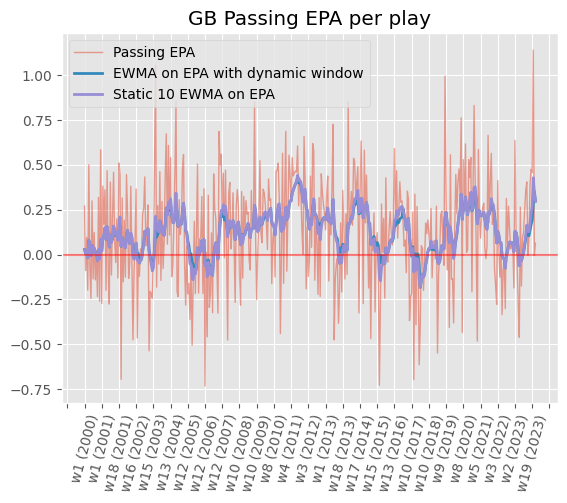

In [40]:
tm = (
    epa.loc[epa["team"] == "GB", :]
    .assign(
        season_week=lambda x: "w"
        + x.week.astype(str)
        + " ("
        + x.season.astype(str)
        + ")"
    )
    .set_index("season_week")
)

fig, ax = plt.subplots()

loc = plticker.MultipleLocator(base=16)  # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.tick_params(axis="x", rotation=75)  # rotate the x-axis labels a bit

ax.plot(tm["epa_shifted_passing_offense"], lw=1, alpha=0.5)
ax.plot(tm["ewma_dynamic_window_passing_offense"], lw=2)
ax.plot(tm["ewma_passing_offense"], lw=2)
plt.axhline(y=0, color="red", lw=1.5, alpha=0.5)

ax.legend(["Passing EPA", "EWMA on EPA with dynamic window", "Static 10 EWMA on EPA"])
ax.set_title("GB Passing EPA per play")
plt.show()

In [41]:
schedule = (
    data[["season", "week", "home_team", "away_team", "home_score", "away_score"]]
    .drop_duplicates()
    .reset_index(drop=True)
    .assign(home_team_win=lambda x: (x.home_score > x.away_score).astype(int))
)

df = schedule.merge(
    epa.rename(columns={"team": "home_team"}), on=["home_team", "season", "week"]
).merge(
    epa.rename(columns={"team": "away_team"}),
    on=["away_team", "season", "week"],
    suffixes=("_home", "_away"),
)

df.head()

,season,week,home_team,...,epa_shifted_passing_defense_away,ewma_passing_defense_away,ewma_dynamic_window_passing_defense_away
0,2000,1,NYG,...,0.269840,0.115978,0.115978
1,2000,1,PIT,...,-0.314740,-0.201766,-0.201766
2,2000,1,WAS,...,-0.368611,0.001226,0.001226
3,2000,1,MIN,...,0.365886,0.106318,0.106318
4,2000,1,LA,...,-0.078273,-0.086481,-0.086481


In [42]:
target = "home_team_win"
features = [column for column in df.columns if "ewma" in column and "dynamic" in column]
for feature in features:
    print(feature)

ewma_dynamic_window_rushing_offense_home
ewma_dynamic_window_passing_offense_home
ewma_dynamic_window_rushing_defense_home
ewma_dynamic_window_passing_defense_home
ewma_dynamic_window_rushing_offense_away
ewma_dynamic_window_passing_offense_away
ewma_dynamic_window_rushing_defense_away
ewma_dynamic_window_passing_defense_away


In [43]:
df = df.dropna()

# Separate the data into X and y
X = df.loc[df["season"] != TEST_YEAR, features].values
y = df.loc[df["season"] != TEST_YEAR, target].values

In [44]:
# Logistic Regression Model
clf = LogisticRegression()
clf.fit(X, y)

LogisticRegression()

In [45]:
# Logistic Regression Model Cross Validation
accuracy_scores = cross_val_score(clf, X, y, cv=10)
log_losses = cross_val_score(clf, X, y, cv=10, scoring="neg_log_loss")

print(f"Model Accuracy: {np.mean(accuracy_scores)} (+/- {np.std(accuracy_scores) * 2})")
print("Neg log loss:", np.mean(log_losses))

Model Accuracy: 0.6343400201807906 (+/- 0.04296017437183735)
Neg log loss: -0.6392864482468561


In [46]:
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# Individual models
clf1 = LogisticRegression()
clf2 = RandomForestClassifier()
clf3 = MLPClassifier()

# Ensemble model
ensemble = VotingClassifier(
    estimators=[("lr", clf1), ("rf", clf2), ("mlp", clf3)], voting="hard"
)

# Fit and evaluate the ensemble
ensemble.fit(X, y)
accuracy_scores = cross_val_score(ensemble, X, y, cv=10, scoring="accuracy")
print(
    f"Ensemble Accuracy: {np.mean(accuracy_scores)} (+/- {np.std(accuracy_scores) * 2})"
)

/Users/joshcaponigro/Documents/Coding/Fantasy-Football-Tools/NFLPredictor/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/joshcaponigro/Documents/Coding/Fantasy-Football-Tools/NFLPredictor/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/joshcaponigro/Documents/Coding/Fantasy-Football-Tools/NFLPredictor/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/joshcaponigro/Documents/Coding/Fantasy-Football-Tools/NFLPredictor/.venv/lib/python3.12/site-packag

Ensemble Accuracy: 0.6307843321779046 (+/- 0.03798247860534971)


In [47]:
from sklearn.ensemble import StackingClassifier

# Base models
base_learners = [("rf", RandomForestClassifier()), ("nn", MLPClassifier(max_iter=1000))]

# Meta-model
stacking_model = StackingClassifier(
    estimators=base_learners, final_estimator=LogisticRegression(), cv=5
)

# Fit and evaluate
stacking_model.fit(X, y)
accuracy_scores = cross_val_score(stacking_model, X, y, cv=5, scoring="accuracy")
print(
    f"Stacking Model Accuracy: {np.mean(accuracy_scores)} (+/- {np.std(accuracy_scores) * 2})"
)

Stacking Model Accuracy: 0.6269023368068298 (+/- 0.029950879799405677)


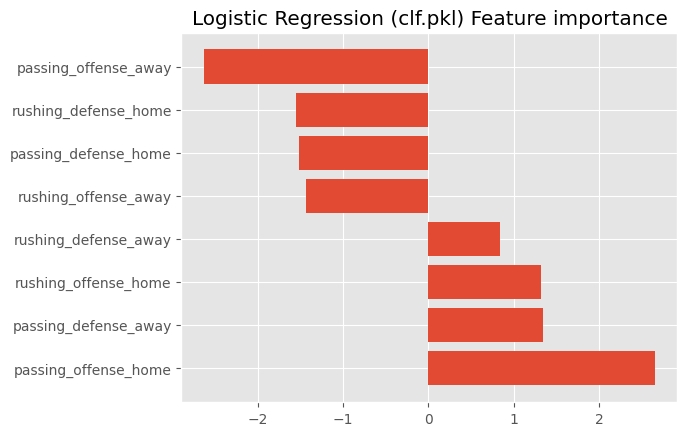

In [48]:
# Feature importance for the logistic regression model
fig, ax = plt.subplots()

feature_names = ["_".join(feature_name.split("_")[3:]) for feature_name in features]

coef_ = clf.coef_[0]

features_coef_sorted = sorted(
    zip(feature_names, coef_), key=lambda x: x[-1], reverse=True
)

features_sorted = [feature for feature, _ in features_coef_sorted]
coef_sorted = [coef for _, coef in features_coef_sorted]

ax.set_title("Logistic Regression (clf.pkl) Feature importance")

ax.barh(features_sorted, coef_sorted)
plt.show()

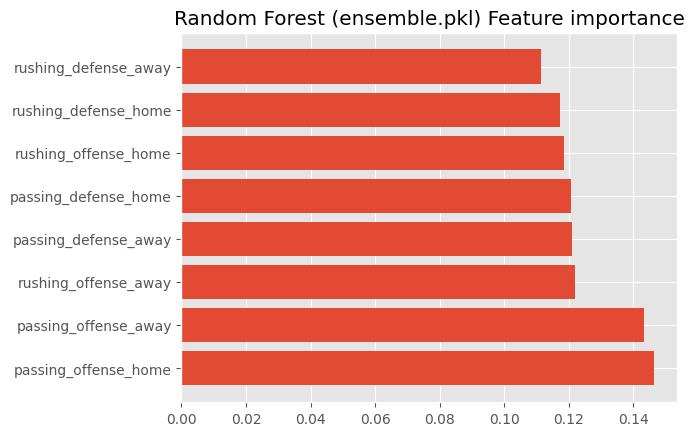

In [49]:
# Feature importance for the ensemble model
fig, ax = plt.subplots()

feature_names = ["_".join(feature_name.split("_")[3:]) for feature_name in features]

coef_ = ensemble.estimators_[1].feature_importances_

features_coef_sorted = sorted(
    zip(feature_names, coef_), key=lambda x: x[-1], reverse=True
)

features_sorted = [feature for feature, _ in features_coef_sorted]
coef_sorted = [coef for _, coef in features_coef_sorted]

ax.set_title("Random Forest (ensemble.pkl) Feature importance")

ax.barh(features_sorted, coef_sorted)
plt.show()

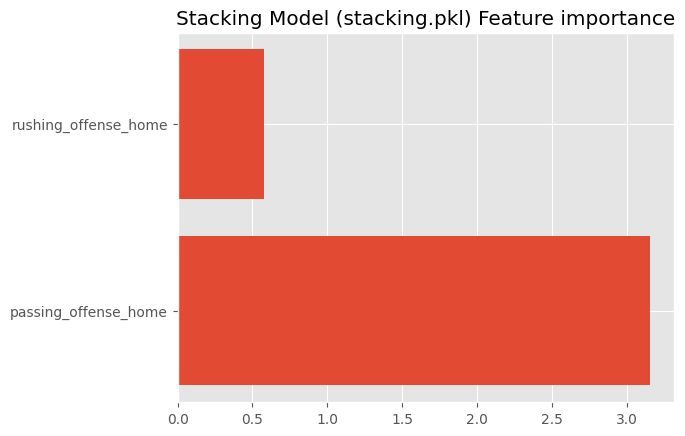

In [50]:
# Feature importance for the stacking model
fig, ax = plt.subplots()

feature_names = ["_".join(feature_name.split("_")[3:]) for feature_name in features]

coef_ = stacking_model.final_estimator_.coef_[0]

features_coef_sorted = sorted(
    zip(feature_names, coef_), key=lambda x: x[-1], reverse=True
)

features_sorted = [feature for feature, _ in features_coef_sorted]
coef_sorted = [coef for _, coef in features_coef_sorted]

ax.set_title("Stacking Model (stacking.pkl) Feature importance")

ax.barh(features_sorted, coef_sorted)
plt.show()

In [52]:
import joblib

# Save the models
joblib.dump(clf, "./models/clf.joblib")
joblib.dump(ensemble, "./models/ensemble.joblib")
joblib.dump(stacking_model, "./models/stacking.joblib")

['./models/stacking.joblib']

In [81]:
# Set model to continue analyzing here:
model = clf

In [82]:
df_target = df.loc[(df["season"] == TEST_YEAR)].assign(
    predicted_winner=lambda x: model.predict(x[features]),
    home_team_win_probability=lambda x: model.predict_proba(x[features])[:, 1],
)[
    [
        "home_team",
        "away_team",
        "week",
        "predicted_winner",
        "home_team_win_probability",
        "home_team_win",
    ]
]

df_target["actual_winner"] = df_target.apply(
    lambda x: x.home_team if x.home_team_win else x.away_team, axis=1
)
df_target["predicted_winner"] = df_target.apply(
    lambda x: x.home_team if x.predicted_winner == 1 else x.away_team, axis=1
)
df_target["win_probability"] = df_target.apply(
    lambda x: (
        x.home_team_win_probability
        if x.predicted_winner == x.home_team
        else 1 - x.home_team_win_probability
    ),
    axis=1,
)
df_target["correct_prediction"] = (
    df_target["predicted_winner"] == df_target["actual_winner"]
).astype(int)

df_target = df_target.drop(columns=["home_team_win_probability", "home_team_win"])

df_target.sort_values(by="win_probability", ascending=False).reset_index(
    drop=True
).head(10)

/Users/joshcaponigro/Documents/Coding/Fantasy-Football-Tools/NFLPredictor/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/joshcaponigro/Documents/Coding/Fantasy-Football-Tools/NFLPredictor/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


,home_team,away_team,week,predicted_winner,actual_winner,win_probability,correct_prediction
0,KC,CHI,3,KC,KC,0.869728,1
1,BUF,NYG,6,BUF,BUF,0.859629,1
2,ARI,SF,15,SF,SF,0.838130,1
3,SF,SEA,14,SF,SF,0.826591,1
4,MIA,NYG,5,MIA,MIA,0.812855,1
5,DAL,NYG,10,DAL,DAL,0.809416,1
6,NYJ,KC,4,KC,KC,0.807900,1
7,HOU,ARI,11,HOU,HOU,0.806968,1
8,PHI,WAS,4,PHI,PHI,0.804309,1
9,MIA,NYJ,15,MIA,MIA,0.800130,1


In [83]:
correct = (
    df_target.loc[df_target["correct_prediction"] == 1]
    .groupby("week")["correct_prediction"]
    .sum()
)

num_games = df_target.groupby("week")["correct_prediction"].size()

results = correct / num_games

results

week
1     0.500000
2     0.562500
3     0.750000
4     0.625000
5     0.428571
6     0.733333
7     0.153846
8     0.562500
9     0.857143
10    0.642857
11    0.714286
12    0.562500
13    0.692308
14    0.466667
15    0.625000
16    0.625000
17    0.750000
18    0.625000
19    0.833333
20    0.750000
21    0.500000
22         NaN
Name: correct_prediction, dtype: float64

In [84]:
# Total correctness and avg correctness by week
correct.sum() / num_games.sum(), results.mean()

(np.float64(0.6105263157894737), np.float64(0.6171354439211582))

In [85]:
display(
    df_target.loc[df_target["week"] == results.idxmax()].sort_values(
        by="win_probability", ascending=False
    )
)

,home_team,away_team,week,predicted_winner,actual_winner,win_probability,correct_prediction
6284,NO,CHI,9,NO,NO,0.743312,1
6282,CLE,ARI,9,CLE,CLE,0.669258,1
6292,BAL,SEA,9,BAL,BAL,0.660237,1
6293,HOU,TB,9,HOU,HOU,0.645699,1
6285,PHI,DAL,9,PHI,PHI,0.598191,1
6283,CIN,BUF,9,BUF,CIN,0.579449,0
6287,NYJ,LAC,9,LAC,LAC,0.573882,1
6294,PIT,TEN,9,PIT,PIT,0.563903,1
6291,LV,NYG,9,LV,LV,0.554500,1
6289,KC,MIA,9,KC,KC,0.552374,1


In [86]:
df_target.loc[df_target["week"] == 2]

,home_team,away_team,week,predicted_winner,actual_winner,win_probability,correct_prediction
6176,CIN,BAL,2,CIN,BAL,0.611062,0
6177,TB,CHI,2,TB,TB,0.763775,1
6178,PIT,CLE,2,PIT,PIT,0.568549,1
6179,ATL,GB,2,GB,ATL,0.561199,0
6180,HOU,IND,2,HOU,IND,0.615482,0
6181,JAX,KC,2,KC,KC,0.505520,1
6182,TEN,LAC,2,LAC,TEN,0.584432,0
6183,BUF,LV,2,BUF,BUF,0.611854,1
6184,NE,MIA,2,MIA,MIA,0.501354,1
6185,PHI,MIN,2,PHI,PHI,0.658694,1


In [87]:
# How many predictions with win probability above 60% are correct?
df_target.loc[df_target["win_probability"] > 0.6, "correct_prediction"].mean()

np.float64(0.6622516556291391)

In [88]:
# How many predictions with win probability above 70% are correct?
df_target.loc[df_target["win_probability"] > 0.7, "correct_prediction"].mean()

np.float64(0.6774193548387096)

In [89]:
# How many predictions with win probability above 75% are correct?
df_target.loc[df_target["win_probability"] > 0.75, "correct_prediction"].mean()

np.float64(0.7647058823529411)

In [90]:
# How many predictions with win probability above 80% are correct?
df_target.loc[df_target["win_probability"] > 0.8, "correct_prediction"].mean()

np.float64(1.0)

In [91]:
# How many predictions with win probability above 85% are correct?
df_target.loc[df_target["win_probability"] > 0.8, "correct_prediction"].mean()

np.float64(1.0)

In [92]:
import itertools

HOME_TEAM = "NYJ"
AWAY_TEAM = "NE"


def ewma(data, window):
    """
    Calculate the most recent value for EWMA given an array of data and a window size
    """
    alpha = 2 / (window + 1.0)
    alpha_rev = 1 - alpha
    scale = 1 / alpha_rev
    n = data.shape[0]
    r = np.arange(n)
    scale_arr = scale**r
    offset = data[0] * alpha_rev ** (r + 1)
    pw0 = alpha * alpha_rev ** (n - 1)
    mult = data * pw0 * scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums * scale_arr[::-1]
    return out[-1]


data_2024 = data.loc[(data["season"] == 2024)]
offense = data_2024.loc[
    (data_2024["posteam"] == HOME_TEAM) | (data_2024["posteam"] == AWAY_TEAM)
]
defense = data_2024.loc[
    (data_2024["defteam"] == HOME_TEAM) | (data_2024["defteam"] == AWAY_TEAM)
]

rushing_offense = (
    offense.loc[offense["rush_attempt"] == 1]
    .groupby(["posteam", "week"], as_index=False)["epa"]
    .mean()
    .rename(columns={"posteam": "team"})
)
passing_offense = (
    offense.loc[offense["pass_attempt"] == 1]
    .groupby(["posteam", "week"], as_index=False)["epa"]
    .mean()
    .rename(columns={"posteam": "team"})
)
rushing_defense = (
    defense.loc[defense["rush_attempt"] == 1]
    .groupby(["defteam", "week"], as_index=False)["epa"]
    .mean()
    .rename(columns={"defteam": "team"})
)
passing_defense = (
    defense.loc[defense["pass_attempt"] == 1]
    .groupby(["defteam", "week"], as_index=False)["epa"]
    .mean()
    .rename(columns={"defteam": "team"})
)

super_bowl_X = np.zeros(8)

for i, (tm, stat_df) in enumerate(
    itertools.product(
        [HOME_TEAM, AWAY_TEAM],
        [rushing_offense, passing_offense, rushing_defense, passing_defense],
    )
):
    ewma_value = ewma(stat_df.loc[stat_df["team"] == tm]["epa"].values, 20)
    super_bowl_X[i] = ewma_value

predicted_winner = clf.predict(super_bowl_X.reshape(1, 8))[0]
predicted_proba = clf.predict_proba(super_bowl_X.reshape(1, 8))[0]

winner = HOME_TEAM if predicted_winner else AWAY_TEAM
win_prob = predicted_proba[-1] if predicted_winner else predicted_proba[0]

In [93]:
winner, win_prob

('NE', np.float64(0.5803249751598882))